# TEXT CLASSIFICATION WITH TRANSFORMERS LIBRARY

In this notebook we are going to use the transformers library to fine tune a model for emotion recognition in short texts.


## Step1. Install, Import and Load Data

In [ ]:
!pip install transformers[torch]
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00


Load and inspect the dataset:

In [ ]:
from datasets import load_dataset
emotions = load_dataset("emotion")

In [ ]:
list(emotions.keys())

['train', 'validation', 'test']

In [ ]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
len(emotions["train"])

16000

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's see the distribution of labels in this dataset:

In [ ]:
emo_train_df = emotions["train"].to_pandas()

In [ ]:
emo_train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
emo_train_df["label"].value_counts()/emo_train_df.shape[0]

1    0.335125
0    0.291625
3    0.134937
4    0.121063
2    0.081500
5    0.035750
Name: label, dtype: float64

In [ ]:
emo_test_df = emotions["test"].to_pandas()
emo_test_df["label"].value_counts()/emo_test_df.shape[0]

1    0.3475
0    0.2905
3    0.1375
4    0.1120
2    0.0795
5    0.0330
Name: label, dtype: float64

## Step2. Preprocess Data

Tokenize the text taking into account the transformer limits and variable size of texts

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased" #recommended: microsoft/MiniLM-L12-H384-uncased
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

### Creating training batches from samples

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

#we can adjust the model to another set of labels with the argument ignore_mismatched_sizes=True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
labels = emotions_encoded["train"].features['label'].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

We adopt the Evaluation Metrics from sklearn package

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Configuring the trainer with hyperparameters and datasets

In [ ]:
import os

if not os.path.isdir("results"):
   os.mkdir("results")

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64

logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=1, #10
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", #"epochs"
                                  #logging_steps = len(emotions["train"]) // batch_size
                                  fp16 = True, #speed optimization
                                  #eval_steps = 50,
                                  #save_strategy="no",
                                  disable_tqdm=False)

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])


### Training and evaluation of the model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=250, training_loss=0.2652741394042969, metrics={'train_runtime': 75.3562, 'train_samples_per_second': 212.325, 'train_steps_per_second': 3.318, 'total_flos': 715358872512000.0, 'train_loss': 0.2652741394042969, 'epoch': 1.0})

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 0.21297524869441986,
 'eval_accuracy': 0.922,
 'eval_f1': 0.9223191206827869,
 'eval_runtime': 2.4744,
 'eval_samples_per_second': 808.286,
 'eval_steps_per_second': 12.933,
 'epoch': 1.0}

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.21297524869441986,
 'test_accuracy': 0.922,
 'test_f1': 0.9223191206827869,
 'test_runtime': 2.6891,
 'test_samples_per_second': 743.733,
 'test_steps_per_second': 11.9}

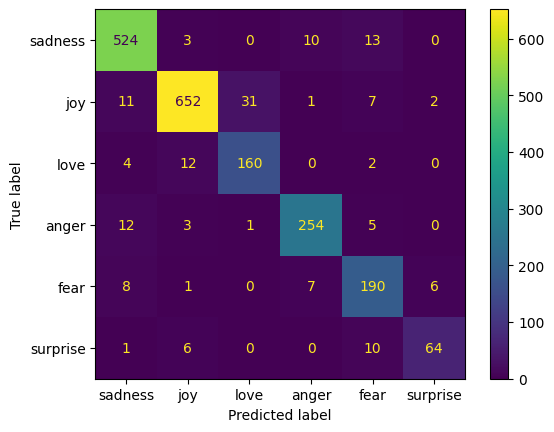

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_valid = np.array(emotions_encoded["validation"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


cm = confusion_matrix(y_valid, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### Save the model

In [ ]:
if not os.path.isdir("model"):
   os.mkdir("model")

model.save_pretrained('./model')
tokenizer.save_pretrained('./model')

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

In [ ]:
!tar -czf model_emotions.tgz model/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp model_emotions.tgz "/content/drive/MyDrive/Colab Notebooks/NLP-Text Mining"

In [ ]:
#model.push_to_hub('bert-base-uncased-emotion')